In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [33]:
#creating df with takehome user data
df_users = pd.read_csv('takehome_users.csv', encoding = "latin-1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
#first glance at users data
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
#changing creation time to datetime format
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])

In [5]:
#creating df with engagement data
df_engage = pd.read_csv('takehome_user_engagement.csv')
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
#first glance at engage data
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
#changing time stamp to datetime format
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])

In [8]:
#setting index to time stamp column, removing old time stamp column
df_engage.index=df_engage['time_stamp']
df_engage.drop(labels='time_stamp',axis=1,inplace=True)
df_engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [9]:
#grouping by user and resampling by week
df_grouped = df_engage.groupby('user_id').resample('1W').sum()
#removing weeks with no user id info
df_grouped = df_grouped[df_grouped['user_id'].isnull() == False].drop('user_id', axis = 1)
df_grouped.head(20)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2
        2014-02-23        0
        2014-03-02        0
        2014-03-09        1
        2014-03-16        1
        2014-03-23        0

In [10]:
#creating df containing info on when users visited 3 or more times in a week
users_active = df_grouped['visited'] >= 3
#grouping users and summing number of weeks with 3 or more visits
users_active = users_active.groupby(level=0).apply(np.sum)
#removing users with no weeks containing 3 or more visits
users_active = users_active[users_active != 0]
users_active = pd.DataFrame(users_active, index = users_active.index)
users_active.columns = ['Active Weeks']
users_active.head()

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [11]:
#merging data into one new df
active_users_df = users_active.merge(df_users, left_index = True, right_on = 'object_id', how = 'inner')
active_users_df.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [12]:
#creating new column "active" that will show only users active (whole df)
active_users_df['Active'] = 1

In [13]:
#adding active column to main df
df_users['Active'] = int(0)
#changing active column to one for active users
df_users.iloc[list(active_users_df.index),10]=1
#creating new df for modeling with object id as index
model_df = df_users.set_index('object_id').sort_index()
model_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [14]:
#removing unneccesary columns for modeling
model_df = model_df.drop(['name','email','last_session_creation_time'], axis = 1)
date_feature = model_df.pop('creation_time')
model_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [15]:
#checking for nulls
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          6417 non-null   float64
 5   Active                      12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 656.2+ KB


In [16]:
#filling nulls in invited by user id with 0
model_df['invited_by_user_id'] = model_df['invited_by_user_id'].fillna(0)
#replacing any data in invited by user id with 1 if its not 0
model_df['invited_by_user_id'] = model_df['invited_by_user_id'].apply(
        lambda x: 1 if x != 0 else 0)
#changing creation source into dummy data
model_df = pd.get_dummies(data = model_df, columns = ['creation_source'])

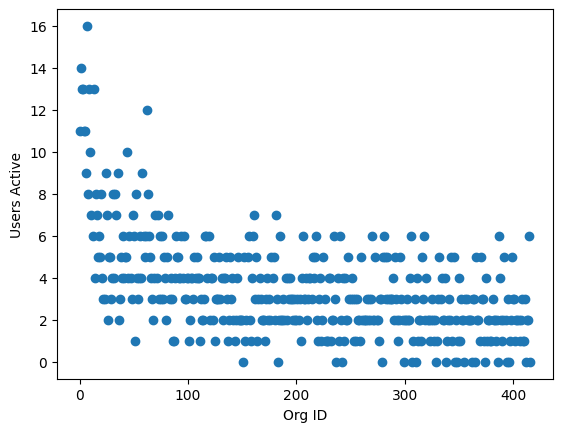

In [17]:
#plotting active users vs org id's
org_group = model_df.groupby('org_id').sum()
plt.scatter(org_group.index, org_group['Active'])
plt.ylabel('Users Active')
plt.xlabel('Org ID')
plt.show()

In [18]:
#changing org_id to least numbers and only for those active
org_data = []
for i in model_df['org_id']:
    data = org_group.loc[i, 'Active']
    org_data.append(data)
model_df['org_id'] = org_data
model_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,0,7,1,0,1,0,0,0,0
2,0,0,14,1,1,0,1,0,0,0
3,0,0,6,1,0,0,1,0,0,0
4,0,0,14,1,0,1,0,0,0,0
5,0,0,3,1,0,1,0,0,0,0


In [19]:
#one hot encoding org_id
model_df = pd.get_dummies(data = model_df, columns = ['org_id'])
model_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#setting active as target, creating train test split with 25% of data
y = model_df.pop('Active')
x = model_df
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .25, random_state = 12)

In [21]:
#using gridsearch cv with 5 folds to determine the best hyperparameters for gradient boosting
gradient_boost = GradientBoostingClassifier(max_features = 'sqrt')
gradient_parameter = {'n_estimators': [40, 45, 50, 55, 60], 'learning_rate': [.01, .02, .03, .04, .05], 'max_depth': [1, 2, 3, 4, 5]}
grid_1 = GridSearchCV(estimator = gradient_boost, param_grid = gradient_parameter, scoring = 'accuracy', cv = 5)
grid_1.fit(X_train, y_train)
best_parameter_gradient = grid_1.best_params_
best_accuracy_gradient = grid_1.best_score_

In [22]:
#displaying best hyperparameters
print('The Tuned Parameters are:\n',best_parameter_gradient,'\nAchieved %s percent accuracy' %(best_accuracy_gradient*100))

The Tuned Parameters are:
 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 40} 
Achieved 88.00000000000001 percent accuracy


In [31]:
#using best hyperparameters to show most important features
gra_boost = GradientBoostingClassifier(max_features = 'sqrt', n_estimators = 40, learning_rate = .01, max_depth = 1)
gra_boost.fit(X_train, y_train)
feature_coefficient = pd.DataFrame(gra_boost.feature_importances_).transpose()
feature_coefficient.columns = list(model_df.columns)
feature_coefficient.index = ['Gra_Boost']
feature_coefficient.transpose().sort_values(by = 'Gra_Boost', ascending = False)

,Gra_Boost
org_id_6,0.277794
creation_source_PERSONAL_PROJECTS,0.205939
org_id_0,0.169773
org_id_5,0.132339
org_id_1,0.091140
org_id_11,0.042482
org_id_12,0.013897
creation_source_GUEST_INVITE,0.013531
creation_source_SIGNUP_GOOGLE_AUTH,0.012809
org_id_14,0.012016


The list above is the importance of each feature, with the top being most important. There were 5 features that were far higher than everything else with "org_id_6" and "creation_source_PERSONAL_PROJECTS" being the top two by a large margin. This would show that users from the 6th org and users who were invited to join another users workspace tend to remain active.